# 0->2 state schedule calibration routine
With this project I intend to use a higher energy state (the 2 state) to perform random number generation and afterwards a quantum random optimization of an objective function. The main difference between this implementation and an implementation using only the $ |0> $ and $ |1> $ states is the potential increase of available random numbers for the same amount of qubits. The random number generator implemented in this notebook already works on circuits to create any of $ 2^n $ different random numbers, where n is the amount of qubits. With the inclusion of the $ |2> $ state, the same algorithm may create any of $ 3^n $ different random numbers, an important increase that can be useful for creating more quality random numbers on NISQ computers with a small amount of qubits, like ibmq_bogota.

The project is comprised of three main activities:
- First a calibration routine of a |2> state schedule to access the higher energy state, leaving a ready-to-use three dimensional X gate. (Most of the code from this activity was found in https://qiskit.org/textbook/ch-quantum-hardware/accessing_higher_energy_states.html)
- I then demonstrate random number generation using the calibrated schedule.
- Finally a quantum random optimization is performed with random numbers generated in the same way.

# 0->1 state schedule

The first step is to calibrate a $ |1> $ state schedule using a frequency sweep and Rabi oscillations.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import SamplePulse

from qiskit.tools.monitor import job_monitor

In [24]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_bogota')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

ibmqfactory.load_account:WARNING:2021-04-11 03:53:37,357: Credentials are already in use. The existing account in the session will be replaced.


Qubit 0 has an estimated frequency of 5.00043029529132 GHz.


In [25]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [26]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [27]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [28]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [29]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [30]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.3)

The frequency sweep will go from 4.9804302952913195 GHz to 5.02043029529132 GHz using 75 frequencies. The drive power is 0.3.


In [31]:
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [32]:
print(ground_freq_sweep_job.job_id())
job_monitor(ground_freq_sweep_job)

6072b910b5717367cd97e68a
Job Status: job has successfully run


In [33]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(ground_freq_sweep_job, average=True)

In [34]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [35]:
# do fit in Hz
(ground_sweep_fit_params, 
 ground_sweep_y_fit) = fit_function(ground_sweep_freqs,
                                   ground_freq_sweep_data, 
                                   lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [7, 4.975*GHz, 1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

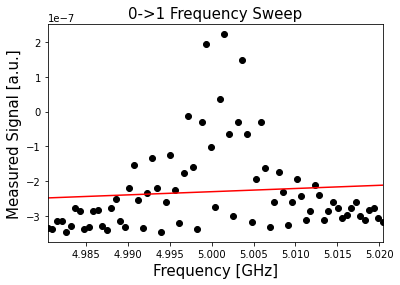

In [36]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_sweep_freqs/GHz, ground_sweep_y_fit, color='red')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [38]:
index = np.array(ground_freq_sweep_data).argmax()
cal_qubit_freq = ground_sweep_freqs[index]

In [40]:
cal_qubit_freq = default_qubit_freq

In [41]:
#_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 5.0004303 GHz to 5.0004303 GHz.


In [42]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [43]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name='rabi_01_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)

In [44]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [45]:
rabi_01_job = backend.run(rabi_01_expt_program)

In [46]:
print(rabi_01_job.job_id())
job_monitor(rabi_01_job)

6072b9b02f5a612e488f6217
Job Status: job has successfully run


In [47]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True)

In [48]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

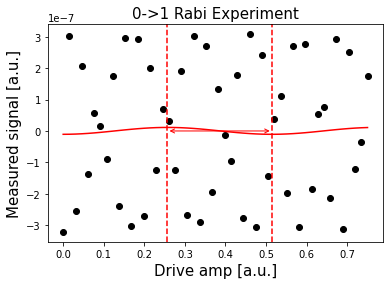

In [51]:
# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, -4, 0.5, 0])

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
#plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()

In [52]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.2570383080839592


In [53]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

# 1->2 state schedule

The second step is to calibrate a $ |1> - |2> $ state schedule using a frequency sweep and Rabi oscillations too.

In [54]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = SamplePulse(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse    

In [55]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.60043029529132 GHz to 5.03043029529132 GHz using 75 frequencies. The drive power is 0.3.


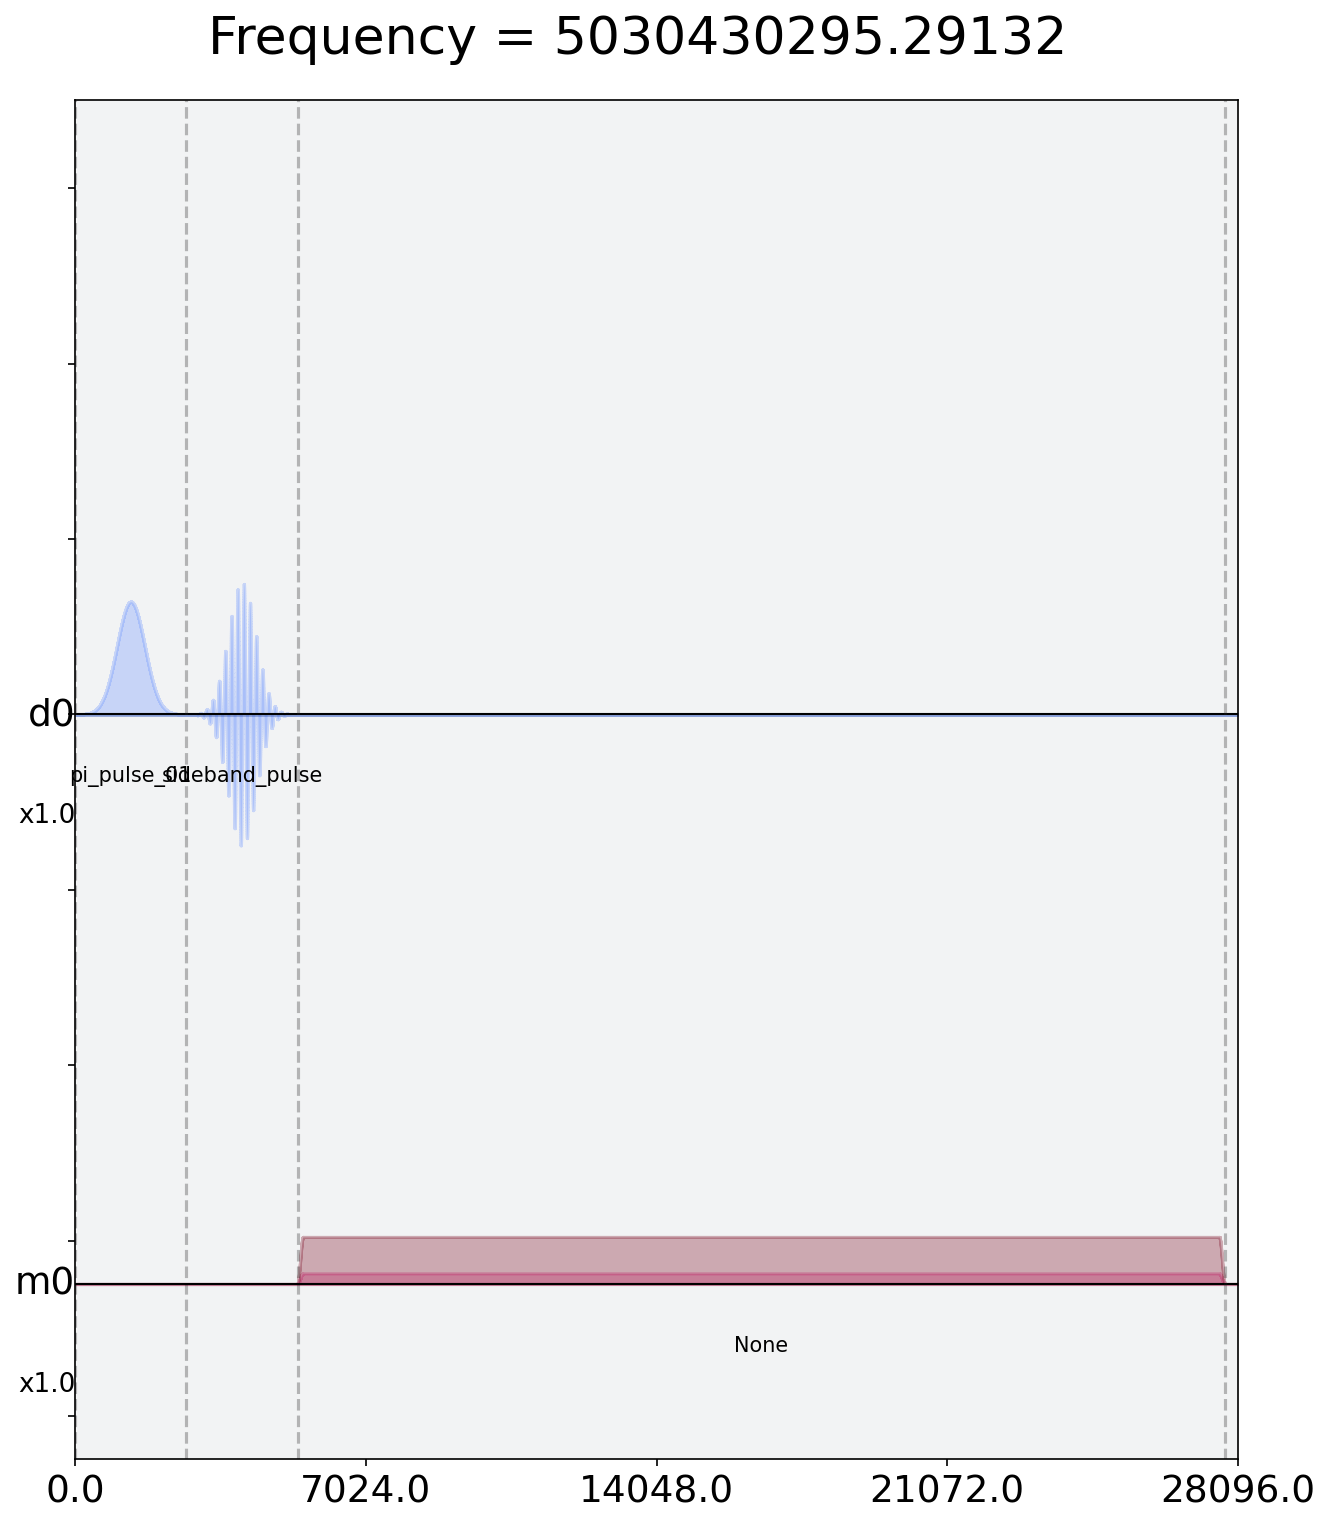

In [56]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = cal_qubit_freq + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [57]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

In [58]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

6072b9f5b10d9520a4609771
Job Status: job has successfully run


In [59]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

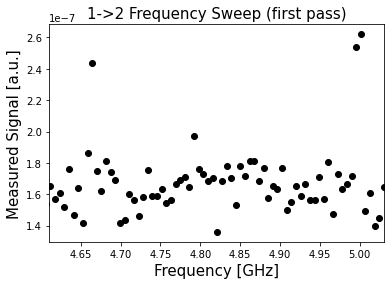

In [60]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [61]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [65]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 2.4e-7)
approx_12_freq = maxima[0]

Freq. dips:  [4.66434921e+09 5.00137624e+09]


The frequency sweep will go from 4.644349214210238 GHz to 4.684349214210238 GHz using 75 frequencies. The drive power is 0.3.


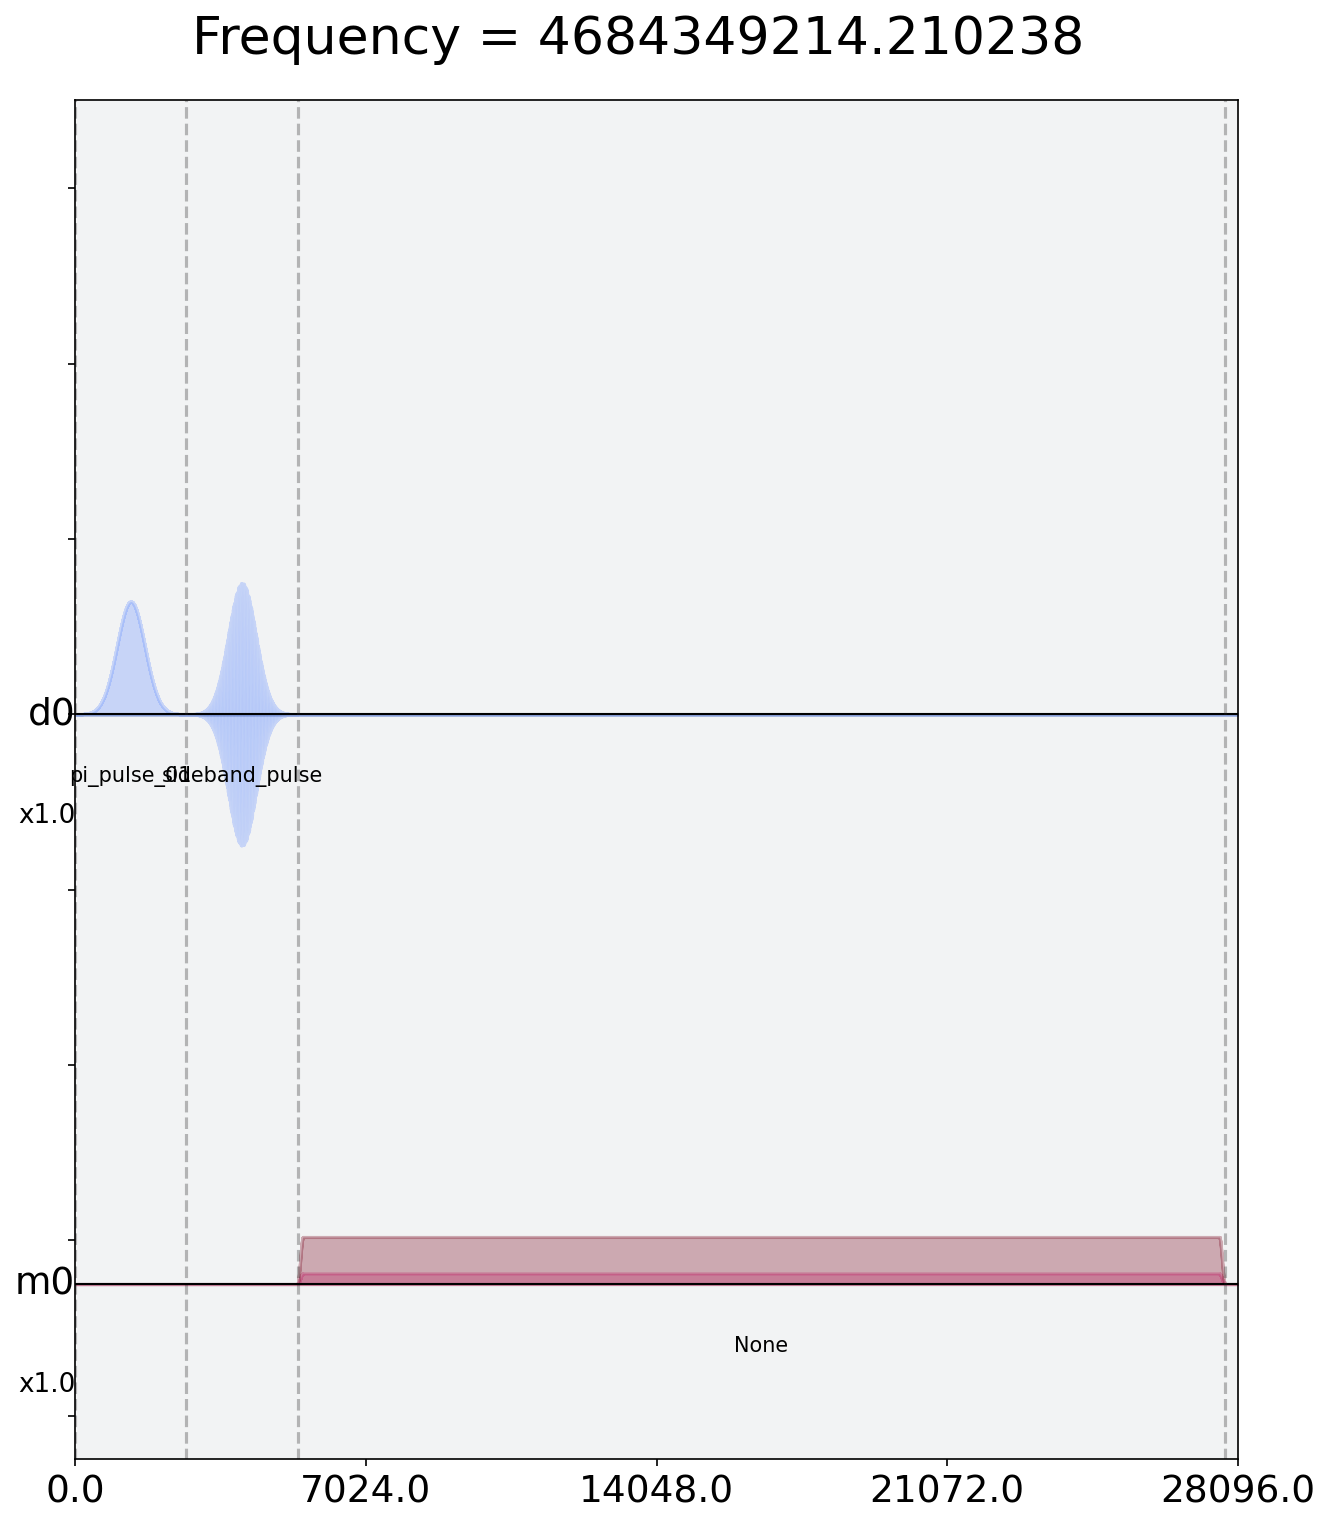

In [67]:
# smaller range refined sweep
num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [68]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

In [69]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

6072bb115b466e7d7b10a09a
Job Status: job has successfully run


In [70]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

In [71]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

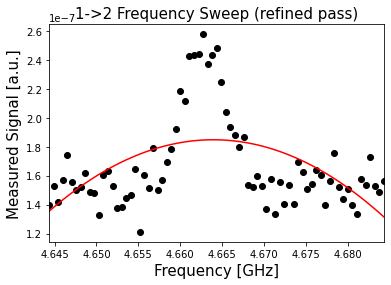

In [72]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [73]:
index = np.array(refined_excited_freq_sweep_data).argmax()
qubit_12_freq = refined_excited_sweep_freqs[index]

In [74]:
#_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6627276 GHz.


In [75]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [76]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [77]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [78]:
rabi_12_job = backend.run(rabi_12_expt_program)

In [79]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

6072bb96dbfb943a7e27a5e2
Job Status: job has successfully run


In [80]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

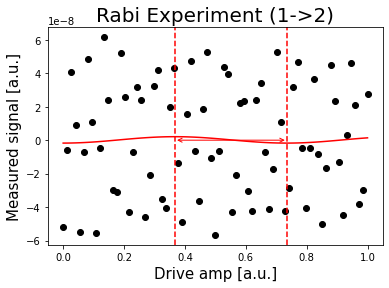

In [81]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [3, 0.5, 0.9, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
#plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [82]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6627276 GHz.
Pi Amplitude (1->2) = 0.3675043942181431


In [83]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

In [84]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

In [85]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

In [86]:
IQ_012_job = backend.run(IQ_012_program)

In [87]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

6072bbe701ba9616b9179ffb
Job Status: job has successfully run


In [88]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [91]:
two_data

array([-3.9115256e-07-1.04698424e-06j,  4.5560548e-07-8.93501360e-07j,
       -2.3081644e-07-7.17775520e-07j, ...,
        5.4394000e-07-4.66129840e-07j,  5.9252536e-07-2.20355360e-07j,
        2.0817464e-07-4.26374280e-07j])

In [89]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

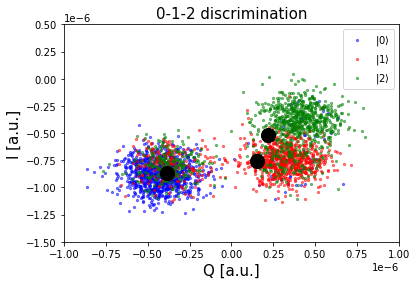

In [98]:
x_min = -10e-7
x_max = 10e-7
y_min = -15e-7
y_max = 5e-7
IQ_012_plot(x_min, x_max, y_min, y_max)

In [100]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [101]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


In [102]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

3072


In [103]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [104]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[2. 0. 0.]


In [105]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.7415364583333334


In [108]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

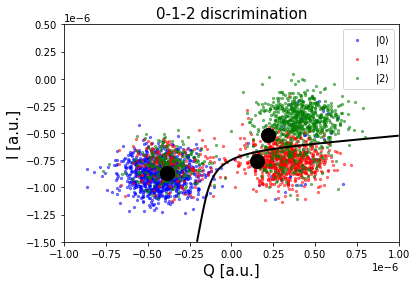

In [109]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

# Gate creation

In [111]:
from qiskit.circuit import Gate

## X2 gate

In [166]:
basis_gates = backend_config.basis_gates
inst_map = backend_defaults.instruction_schedule_map
gate_name = 'X2'
basis_gates += [gate_name]
inst_map.add(gate_name, qubit, one_schedule)
x2_gate = Gate(gate_name, 1, [])

## X3 gate

In [167]:
gate_name = 'X3'
basis_gates += [gate_name]
inst_map.add(gate_name, qubit, two_schedule)
x3_gate = Gate(gate_name, 1, [])

## H2 gate

In [168]:
pi_half_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01/2, 
                                 sigma=drive_sigma,
                                 name='pi_half_pulse_01')

In [169]:
# Excited half state schedule
one_half_schedule = pulse.Schedule(name="one half schedule")
one_half_schedule |= pulse.Play(pi_half_pulse_01, drive_chan)
one_half_schedule |= measure << one_half_schedule.duration

In [170]:
basis_gates = backend_config.basis_gates
inst_map = backend_defaults.instruction_schedule_map
gate_name = 'H2'
basis_gates += [gate_name]
inst_map.add(gate_name, qubit, one_half_schedule)
h2_gate = Gate(gate_name, 1, [])

## H3 gate

In [171]:
pi_half_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12/2, 
                                 sigma=drive_sigma,
                                 name='pi_half_pulse_12')

In [172]:
# Excited half state schedule
two_half_schedule = pulse.Schedule(name="two half schedule")
two_half_schedule |= pulse.Play(pi_half_pulse_01, drive_chan)
two_half_schedule |= pulse.Play(pi_half_pulse_12, drive_chan) << two_half_schedule.duration
two_half_schedule |= measure << two_half_schedule.duration

In [173]:
basis_gates = backend_config.basis_gates
inst_map = backend_defaults.instruction_schedule_map
gate_name = 'H3'
basis_gates += [gate_name]
inst_map.add(gate_name, qubit, two_half_schedule)
h3_gate = Gate(gate_name, 1, [])

# Quantum Number Generator and Quantum random optimization algorithm
Can also be found in https://github.com/Raijeku/Optimization

Here I generate random numbers on 1 qubit of the ibmq_bogota device using the three state schedules previously prepared. At the end is the Quantum Random Optimization algorithm being used in a similar manner.

In [200]:
from sympy import *
import pandas as pd
from qiskit import execute, IBMQ, circuit, QuantumCircuit
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import assemble, schedule
from qiskit.pulse import DriveChannel

def quantum_random_optimization(xl, xu, n, function, backend_name, pulse, num_states, num_qubits):
    x = Symbol('x')
    f = parse_expr(function)
    iteration = 0
    data = pd.DataFrame(columns=['iteration','xl','xu','x','f(x)','max_x','max_f(x)','error'])
    rs = generate_random(n, backend_name, pulse, num_states, num_qubits)

    max_f = -1E9
    max_x = -1E9
    for i in range(n):
        r = rs[i]
        x0 = xl + (xu - xl)*r
        df = f.diff(x)
        fx = f.subs(x, x0)
        dfx = df.subs(x, x0)
        if fx > max_f:
            max_f = fx
            max_x = x0
        data = data.append(pd.DataFrame({'iteration':[iteration], 'xl':[xl], 'xu':[xu], 'x':[x0], 'f(x)':[fx], 'max_x':[max_x], 'max_f(x)':[max_f], 'error':[dfx]}), ignore_index = True)
        iteration += 1

    return data

def generate_random(n, backend_name, pulse=False, num_states=None, num_qubits=None):
    backend_config = backend.configuration()
    if num_qubits==None: num_qubits = backend_config.n_qubits

    if not pulse: 
        circuit = QuantumCircuit(num_qubits,num_qubits)
        for i in range(num_qubits):
            circuit.h(i)

        circuit.measure([i for i in range(num_qubits)],[i for i in range(num_qubits)])
        job = execute(circuit, backend, shots = n, memory = True)
        job = backend.run(program)
        job_monitor(job)
        result = job.result()
        bits = result.get_memory(0)

        random_numbers = []
        for key in bits:
            if len(random_numbers) < n:
                random_numbers.append(int(key, 2)/(2**num_qubits))
            else:
                break
            
    else: 
        drive_chan_0 = DriveChannel(0)
        backend_defaults = backend.defaults()
        center_frequency_Hz_0 = backend_defaults.qubit_freq_est[0]
        schedules = [zero_schedule, one_half_schedule, two_schedule]
        program = assemble(schedules,
            backend=backend, 
            meas_level=1,
            meas_return='single',
            shots=n,
            schedule_los=[{drive_chan_0: center_frequency_Hz_0}] * len(schedules))
        job = backend.run(program)
        job_monitor(job)
        result = job.result()
        data = np.zeros((n*3,2))
        print(result.get_memory(0))
        data[:n,0] = result.get_memory(0)[:, 0].real
        data[:n,1] = result.get_memory(0)[:, 0].imag
        data[n:2*n,0] = result.get_memory(1)[:, 0].real
        data[n:2*n,1] = result.get_memory(1)[:, 0].imag
        data[2*n:,0] = result.get_memory(2)[:, 0].real
        data[2*n:,1] = result.get_memory(2)[:, 0].imag
        bits = LDA_012.predict(data)
        
        random_numbers = []
        for integer in bits:
            if len(random_numbers) < 3*n:
                random_numbers.append(integer/(3**num_qubits))
            else:
                break
    
    return random_numbers

In [195]:
numbers = np.array(generate_random(100,'ibmq_bogota', pulse=True, num_states=3, num_qubits=1))

Job Status: job has successfully run
[[ 3.7371768e+07-9.68769840e+07j -3.4254336e+07-8.50884960e+07j
  -2.9093508e+07-9.74811120e+07j -1.7706748e+07-1.48551136e+08j
  -5.0767444e+07-1.10725112e+08j]
 [-5.5679400e+07-8.50822720e+07j -2.7031796e+07-5.44361440e+07j
  -4.1727432e+07-8.54240240e+07j -8.6979900e+06-1.22411920e+08j
  -4.4237652e+07-1.31726448e+08j]
 [-3.6982124e+07-9.97883520e+07j -5.3301584e+07-7.75967520e+07j
  -4.9099404e+07-8.78693760e+07j -4.9823204e+07-1.32570712e+08j
  -4.8252692e+07-1.39818000e+08j]
 [-4.3798244e+07-9.00195840e+07j -3.8710696e+07-7.65312880e+07j
  -4.0286368e+07-9.26656240e+07j -1.0721803e+07-1.30119024e+08j
  -5.8341660e+07-1.44003408e+08j]
 [-2.8505800e+07-8.60113360e+07j -3.0526470e+07-6.77946000e+07j
  -3.3606536e+07-6.56622040e+07j -2.2336110e+07-1.19311680e+08j
  -5.5173348e+07-1.41212752e+08j]
 [-4.5049584e+07-7.46000640e+07j  3.1732004e+07-5.57240440e+07j
  -2.7144536e+07-1.05583808e+08j -6.4595464e+07-1.24621712e+08j
  -7.4949752e+07-1.086138

array([0.33333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.66666667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33333333, 0.        , 0.        , 0.     

In [198]:
print('Numbers are:',numbers)

Numbers are: [0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.33333333 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.66666667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.33333333 0.         0.
 0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33333333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

We now perform an optimization of the $-x^2 $ function.

In [201]:
results = quantum_random_optimization(-3,2,1000,'-x**2','ibmq_bogota', True, 3, 1)

Job Status: job has successfully run
[[-53065888.-9.95942160e+07j  12526852.-8.83355040e+07j
  -45737476.-8.78401520e+07j -18069768.-1.35313648e+08j
  -54956012.-1.39740816e+08j]
 [-44805456.-7.83008800e+07j -38067972.-6.56340840e+07j
  -34924432.-8.77824800e+07j -27510968.-1.31698568e+08j
  -58658688.-1.18382784e+08j]
 [-54034328.-9.41902560e+07j -33120974.-7.46284000e+07j
  -25283040.-7.65685840e+07j -25300256.-1.70250528e+08j
  -49047100.-1.45890528e+08j]
 ...
 [-30167272.-8.05575840e+07j -52607480.-6.54034960e+07j
  -33121920.-8.53363840e+07j -68748360.-1.41119392e+08j
  -59052456.-1.09183304e+08j]
 [-32798284.-8.35185840e+07j -28180596.-3.67491560e+07j
  -51425432.-1.07535304e+08j -31844488.-1.60568192e+08j
  -45734372.-1.07996096e+08j]
 [-49765528.-9.47291680e+07j -28781622.-6.83978640e+07j
   60580168.-5.00160880e+07j -50950140.-1.38491680e+08j
  -43629116.-1.02511088e+08j]]


,iteration,xl,xu,x,f(x),max_x,max_f(x),error
0,0,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
1,1,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
2,2,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
3,3,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
4,4,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
...,...,...,...,...,...,...,...,...
995,995,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000
996,996,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000
997,997,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000
998,998,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000


In [203]:
results

,iteration,xl,xu,x,f(x),max_x,max_f(x),error
0,0,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
1,1,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
2,2,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
3,3,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
4,4,-3,2,-3.0,-9.00000000000000,-3.000000,-9.00000000000000,6.00000000000000
...,...,...,...,...,...,...,...,...
995,995,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000
996,996,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000
997,997,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000
998,998,-3,2,-3.0,-9.00000000000000,-1.333333,-1.77777777777778,6.00000000000000
